In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import joblib

**Generating same sequence of random numbers**

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

**Loading dataset**

In [ ]:
df = pd.read_csv('/content/climate_disease_dataset.csv')

**Basic dataset information**

In [ ]:
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst 5 rows:")
print(df.head())
print(f"\nData Info:")
print(df.info())
print(f"\nMissing Values:")
print(df.isnull().sum())

Shape: (34560, 12)

Columns: ['year', 'month', 'country', 'region', 'avg_temp_c', 'precipitation_mm', 'air_quality_index', 'uv_index', 'malaria_cases', 'dengue_cases', 'population_density', 'healthcare_budget']

First 5 rows:
   year  month                country   region  avg_temp_c  precipitation_mm  \
0  2000      1  Palestinian Territory  Central   28.132468        152.083870   
1  2000      2  Palestinian Territory  Central   30.886500        119.591418   
2  2000      3  Palestinian Territory  Central   31.366433         95.876124   
3  2000      4  Palestinian Territory  Central   28.481870        175.315731   
4  2000      5  Palestinian Territory  Central   26.890370        191.445990   

   air_quality_index   uv_index  malaria_cases  dengue_cases  \
0         110.487231  12.000000             53           145   
1          83.467928  12.000000            132            48   
2          93.095292  12.000000             34            80   
3         105.530192   9.395894      

**Feature Engineering**

In [ ]:
def add_lags(df, group_cols=['country', 'region'], targets=['malaria_cases', 'dengue_cases'], lags=[1,2,3,6,12], rolls=[3,6]):
    df = df.sort_values(by=group_cols + ['year', 'month']).reset_index(drop=True)
    for target in targets:
        for lag in lags:
            df[f'{target}_lag_{lag}'] = df.groupby(group_cols)[target].shift(lag)
        for roll in rolls:
            df[f'{target}_roll_mean_{roll}'] = df.groupby(group_cols)[target].transform(lambda x: x.rolling(roll, min_periods=1).mean())
            df[f'{target}_roll_std_{roll}'] = df.groupby(group_cols)[target].transform(lambda x: x.rolling(roll, min_periods=1).std())
    return df

In [ ]:
df = add_lags(df)

In [ ]:
print(df.head())

   year  month         country region  avg_temp_c  precipitation_mm  \
0  2000      1  American Samoa   East   24.046880        275.221450   
1  2000      2  American Samoa   East   27.865871        257.518897   
2  2000      3  American Samoa   East   27.185394        118.270513   
3  2000      4  American Samoa   East   25.036525        179.148943   
4  2000      5  American Samoa   East   24.675325        228.473663   

   air_quality_index   uv_index  malaria_cases  dengue_cases  ...  \
0          32.664808  10.092419              7            36  ...   
1           6.549863   9.489863            136           120  ...   
2          26.385328  12.000000             53            79  ...   
3          12.735504  12.000000             34            82  ...   
4          10.127494  12.000000             85           128  ...   

   malaria_cases_roll_std_6  dengue_cases_lag_1  dengue_cases_lag_2  \
0                       NaN                 NaN                 NaN   
1               

In [ ]:
df = df.fillna(0)

In [ ]:
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
print(df.head())

   year  month         country region  avg_temp_c  precipitation_mm  \
0  2000      1  American Samoa   East   24.046880        275.221450   
1  2000      2  American Samoa   East   27.865871        257.518897   
2  2000      3  American Samoa   East   27.185394        118.270513   
3  2000      4  American Samoa   East   25.036525        179.148943   
4  2000      5  American Samoa   East   24.675325        228.473663   

   air_quality_index   uv_index  malaria_cases  dengue_cases  ...  \
0          32.664808  10.092419              7            36  ...   
1           6.549863   9.489863            136           120  ...   
2          26.385328  12.000000             53            79  ...   
3          12.735504  12.000000             34            82  ...   
4          10.127494  12.000000             85           128  ...   

   dengue_cases_lag_1  dengue_cases_lag_2  dengue_cases_lag_3  \
0                 0.0                 0.0                 0.0   
1                36.0       

In [ ]:
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['quarter'] = df['date'].dt.quarter
print(df.head())

   year  month         country region  avg_temp_c  precipitation_mm  \
0  2000      1  American Samoa   East   24.046880        275.221450   
1  2000      2  American Samoa   East   27.865871        257.518897   
2  2000      3  American Samoa   East   27.185394        118.270513   
3  2000      4  American Samoa   East   25.036525        179.148943   
4  2000      5  American Samoa   East   24.675325        228.473663   

   air_quality_index   uv_index  malaria_cases  dengue_cases  ...  \
0          32.664808  10.092419              7            36  ...   
1           6.549863   9.489863            136           120  ...   
2          26.385328  12.000000             53            79  ...   
3          12.735504  12.000000             34            82  ...   
4          10.127494  12.000000             85           128  ...   

   dengue_cases_lag_6  dengue_cases_lag_12  dengue_cases_roll_mean_3  \
0                 0.0                  0.0                 36.000000   
1             

**Encoding the categorical columns**

In [ ]:
cat_cols = ['country', 'region']
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

**Spliting the data for training and testing based on date**

In [ ]:
X = df.drop(['malaria_cases', 'dengue_cases', 'date'], axis=1)
y = df[['malaria_cases', 'dengue_cases']]

train_mask = df['year'] <= 2021
test_mask = df['year'] >= 2022

X_train = X[train_mask]
y_train = y[train_mask]
X_test = X[test_mask]
y_test = y[test_mask]

print("TRAIN/TEST SPLIT COMPLETED")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Number of features: {X_train.shape[1]}")
print(f"Number of targets: {y_train.shape[1]}")
print(f"\nTrain date range: {df[train_mask]['year'].min()}-{df[train_mask]['year'].max()}")
print(f"Test date range: {df[test_mask]['year'].min()}-{df[test_mask]['year'].max()}")
print(f"\nTrain/Test ratio: {X_train.shape[0]/X_test.shape[0]:.2f}:1")


TRAIN/TEST SPLIT COMPLETED
Training set: 31680 samples
Test set: 2880 samples
Number of features: 152
Number of targets: 2

Train date range: 2000-2021
Test date range: 2022-2023

Train/Test ratio: 11.00:1


In [ ]:
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

print("FEATURE SCALING COMPLETED")
print(f"X_train scaled shape: {X_train_scaled.shape}")
print(f"X_test scaled shape: {X_test_scaled.shape}")
print(f"y_train scaled shape: {y_train_scaled.shape}")
print(f"y_test scaled shape: {y_test_scaled.shape}")
print("\nScaling method: StandardScaler (zero mean, unit variance)")
print("\nSample scaled features (first 3 samples, first 5 features):")
print(X_train_scaled[:3, :5])

joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')
print("Scalers saved: scaler_X.pkl, scaler_y.pkl")

FEATURE SCALING COMPLETED
X_train scaled shape: (31680, 152)
X_test scaled shape: (2880, 152)
y_train scaled shape: (31680, 2)
y_test scaled shape: (2880, 2)

Scaling method: StandardScaler (zero mean, unit variance)

Sample scaled features (first 3 samples, first 5 features):
[[-1.65503185 -1.59325501  0.44627536  0.91221264 -0.37334215]
 [-1.65503185 -1.30357228  0.90060682  0.71654656 -1.16062157]
 [-1.65503185 -1.01388955  0.81965302 -0.82256405 -0.56264773]]
Scalers saved: scaler_X.pkl, scaler_y.pkl


In [ ]:
def build_ann_model(input_dim, output_dim=2):
    """
    Feedforward Neural Network (ANN)

    Architecture:
    - Input Layer: input_dim features
    - Hidden Layer 1: 256 neurons + BatchNorm + Dropout(0.3)
    - Hidden Layer 2: 128 neurons + BatchNorm + Dropout(0.3)
    - Hidden Layer 3: 64 neurons + BatchNorm + Dropout(0.2)
    - Hidden Layer 4: 32 neurons + Dropout(0.2)
    - Output Layer: 2 neurons (malaria & dengue cases)

    Activation: ReLU (hidden), Linear (output for regression)
    """
    model = Sequential([
        # Input + Hidden Layer 1
        Dense(256, activation='relu', input_dim=input_dim,
              kernel_initializer='he_normal', name='hidden_1'),
        BatchNormalization(name='batch_norm_1'),
        Dropout(0.3, name='dropout_1'),

        # Hidden Layer 2
        Dense(128, activation='relu', kernel_initializer='he_normal', name='hidden_2'),
        BatchNormalization(name='batch_norm_2'),
        Dropout(0.3, name='dropout_2'),

        # Hidden Layer 3
        Dense(64, activation='relu', kernel_initializer='he_normal', name='hidden_3'),
        BatchNormalization(name='batch_norm_3'),
        Dropout(0.2, name='dropout_3'),

        # Hidden Layer 4
        Dense(32, activation='relu', kernel_initializer='he_normal', name='hidden_4'),
        Dropout(0.2, name='dropout_4'),

        # Output Layer
        Dense(output_dim, activation='linear', name='output')
    ], name='Disease_Prediction_ANN')

    return model

input_dim = X_train_scaled.shape[1]
ann_model = build_ann_model(input_dim)

In [ ]:
ann_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae', 'mse']
)

print("Model Compiled")

Model Compiled


In [ ]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1
)


In [ ]:
model_checkpoint = ModelCheckpoint(
    'best_ann_model.h5',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

In [ ]:
callbacks_list = [early_stopping, reduce_lr, model_checkpoint]

In [ ]:
print("Training Model - 20 EPOCHS")

history_20 = ann_model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_split=0.2,
    epochs=20,
    batch_size=32,
    callbacks=callbacks_list,
    verbose=1
)

print("TRAINING COMPLETED (20 EPOCHS)")

print(f"Actual epochs trained: {len(history_20.history['loss'])}")
print(f"Final training loss: {history_20.history['loss'][-1]:.6f}")
print(f"Final validation loss: {history_20.history['val_loss'][-1]:.6f}")
print(f"Final training MAE: {history_20.history['mae'][-1]:.6f}")
print(f"Final validation MAE: {history_20.history['val_mae'][-1]:.6f}")

y_pred_scaled_20 = ann_model.predict(X_test_scaled, verbose=0)
y_pred_20 = scaler_y.inverse_transform(y_pred_scaled_20)
r2_malaria_20 = r2_score(y_test['malaria_cases'], y_pred_20[:, 0])
r2_dengue_20 = r2_score(y_test['dengue_cases'], y_pred_20[:, 1])

print(f"\nRESULTS (20 EPOCHS):")
print(f"  R² Malaria: {r2_malaria_20:.4f}")
print(f"  R² Dengue:  {r2_dengue_20:.4f}")
print("="*60)

TRAINING MODEL - 20 EPOCHS (QUICK TEST)
Epoch 1/20
791/792 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.4818 - mae: 0.9688 - mse: 1.4818
Epoch 1: val_loss improved from inf to 0.70145, saving model to best_ann_model.h5


792/792 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 1.4808 - mae: 0.9685 - mse: 1.4808 - val_loss: 0.7015 - val_mae: 0.7148 - val_mse: 0.7015 - learning_rate: 0.0010
Epoch 2/20
782/792 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7034 - mae: 0.7012 - mse: 0.7034
Epoch 2: val_loss improved from 0.70145 to 0.44309, saving model to best_ann_model.h5


792/792 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.7024 - mae: 0.7006 - mse: 0.7024 - val_loss: 0.4431 - val_mae: 0.5510 - val_mse: 0.4431 - learning_rate: 0.0010
Epoch 3/20
781/792 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3701 - mae: 0.4888 - mse: 0.3701
Epoch 3: val_loss improved from 0.44309 to 0.33472, saving model to best_ann_model.h5


792/792 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.3692 - mae: 0.4882 - mse: 0.3692 - val_loss: 0.3347 - val_mae: 0.4627 - val_mse: 0.3347 - learning_rate: 0.0010
Epoch 4/20
787/792 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2033 - mae: 0.3585 - mse: 0.2033
Epoch 4: val_loss improved from 0.33472 to 0.32581, saving model to best_ann_model.h5


792/792 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.2033 - mae: 0.3585 - mse: 0.2033 - val_loss: 0.3258 - val_mae: 0.4534 - val_mse: 0.3258 - learning_rate: 0.0010
Epoch 5/20
789/792 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1676 - mae: 0.3241 - mse: 0.1676
Epoch 5: val_loss improved from 0.32581 to 0.31486, saving model to best_ann_model.h5


792/792 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.1676 - mae: 0.3241 - mse: 0.1676 - val_loss: 0.3149 - val_mae: 0.4471 - val_mse: 0.3149 - learning_rate: 0.0010
Epoch 6/20
792/792 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1501 - mae: 0.3068 - mse: 0.1501
Epoch 6: val_loss improved from 0.31486 to 0.28927, saving model to best_ann_model.h5


792/792 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - loss: 0.1501 - mae: 0.3068 - mse: 0.1501 - val_loss: 0.2893 - val_mae: 0.4300 - val_mse: 0.2893 - learning_rate: 0.0010
Epoch 7/20
791/792 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1415 - mae: 0.2966 - mse: 0.1415
Epoch 7: val_loss improved from 0.28927 to 0.27690, saving model to best_ann_model.h5


792/792 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 0.1415 - mae: 0.2966 - mse: 0.1415 - val_loss: 0.2769 - val_mae: 0.4242 - val_mse: 0.2769 - learning_rate: 0.0010
Epoch 8/20
783/792 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1310 - mae: 0.2849 - mse: 0.1310
Epoch 8: val_loss improved from 0.27690 to 0.25012, saving model to best_ann_model.h5


792/792 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 0.1310 - mae: 0.2849 - mse: 0.1310 - val_loss: 0.2501 - val_mae: 0.4055 - val_mse: 0.2501 - learning_rate: 0.0010
Epoch 9/20
790/792 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1260 - mae: 0.2804 - mse: 0.1260
Epoch 9: val_loss improved from 0.25012 to 0.23664, saving model to best_ann_model.h5


792/792 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 0.1260 - mae: 0.2804 - mse: 0.1260 - val_loss: 0.2366 - val_mae: 0.3967 - val_mse: 0.2366 - learning_rate: 0.0010
Epoch 10/20
787/792 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1188 - mae: 0.2716 - mse: 0.1188
Epoch 10: val_loss improved from 0.23664 to 0.21774, saving model to best_ann_model.h5


792/792 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.1188 - mae: 0.2716 - mse: 0.1188 - val_loss: 0.2177 - val_mae: 0.3799 - val_mse: 0.2177 - learning_rate: 0.0010
Epoch 11/20
788/792 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1175 - mae: 0.2696 - mse: 0.1175
Epoch 11: val_loss improved from 0.21774 to 0.20353, saving model to best_ann_model.h5


792/792 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.1175 - mae: 0.2696 - mse: 0.1175 - val_loss: 0.2035 - val_mae: 0.3680 - val_mse: 0.2035 - learning_rate: 0.0010
Epoch 12/20
783/792 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1114 - mae: 0.2624 - mse: 0.1114
Epoch 12: val_loss improved from 0.20353 to 0.19397, saving model to best_ann_model.h5


792/792 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.1114 - mae: 0.2624 - mse: 0.1114 - val_loss: 0.1940 - val_mae: 0.3591 - val_mse: 0.1940 - learning_rate: 0.0010
Epoch 13/20
790/792 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1098 - mae: 0.2602 - mse: 0.1098
Epoch 13: val_loss improved from 0.19397 to 0.19294, saving model to best_ann_model.h5


792/792 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1098 - mae: 0.2602 - mse: 0.1098 - val_loss: 0.1929 - val_mae: 0.3578 - val_mse: 0.1929 - learning_rate: 0.0010
Epoch 14/20
786/792 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1075 - mae: 0.2578 - mse: 0.1075
Epoch 14: val_loss did not improve from 0.19294
792/792 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1076 - mae: 0.2578 - mse: 0.1076 - val_loss: 0.1994 - val_mae: 0.3650 - val_mse: 0.1994 - learning_rate: 0.0010
Epoch 15/20
783/792 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1060 - mae: 0.2559 - mse: 0.1060
Epoch 15: val_loss did not improve from 0.19294
792/792 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.1060 - mae: 0.2559 - mse: 0.1060 - val_loss: 0.2036 - val_mae: 0.3667 - val_mse: 0.2036 - learning_rate: 0.0010
Epoch 16/20
788/792 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1024 - mae: 0.2508 - mse: 0.1024
Epoch 16: val_loss did not improve from 0.19294
792/792 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1024 - mae: 0.2509 - mse: 0.

In [ ]:
print("Training Model - 50 EPOCHS")

ann_model_50 = build_ann_model(input_dim)
ann_model_50.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae', 'mse'])

# Train
history_50 = ann_model_50.fit(
    X_train_scaled,
    y_train_scaled,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=callbacks_list,
    verbose=1
)

print("Training Completed (50 EPOCHS)")
print(f"Actual epochs trained: {len(history_50.history['loss'])}")
print(f"Final training loss: {history_50.history['loss'][-1]:.6f}")
print(f"Final validation loss: {history_50.history['val_loss'][-1]:.6f}")
print(f"Final training MAE: {history_50.history['mae'][-1]:.6f}")
print(f"Final validation MAE: {history_50.history['val_mae'][-1]:.6f}")

y_pred_scaled_50 = ann_model_50.predict(X_test_scaled, verbose=0)
y_pred_50 = scaler_y.inverse_transform(y_pred_scaled_50)
r2_malaria_50 = r2_score(y_test['malaria_cases'], y_pred_50[:, 0])
r2_dengue_50 = r2_score(y_test['dengue_cases'], y_pred_50[:, 1])

print(f"\nRESULTS (50 EPOCHS):")
print(f"  R² Malaria: {r2_malaria_50:.4f}")
print(f"  R² Dengue:  {r2_dengue_50:.4f}")
print("="*60)

Training Model - 50 EPOCHS
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


781/792 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.6173 - mae: 1.0075 - mse: 1.6173
Epoch 1: val_loss did not improve from 0.19294
792/792 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 1.6102 - mae: 1.0054 - mse: 1.6102 - val_loss: 0.7393 - val_mae: 0.7333 - val_mse: 0.7393 - learning_rate: 0.0010
Epoch 2/50
789/792 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7219 - mae: 0.7101 - mse: 0.7219
Epoch 2: val_loss did not improve from 0.19294
792/792 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.7215 - mae: 0.7099 - mse: 0.7215 - val_loss: 0.4831 - val_mae: 0.5770 - val_mse: 0.4831 - learning_rate: 0.0010
Epoch 3/50
780/792 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3950 - mae: 0.5060 - mse: 0.3950
Epoch 3: val_loss did not improve from 0.19294
792/792 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.3939 - mae: 0.5052 - mse: 0.3939 - val_loss: 0.3577 - val_mae: 0.4831 - val_mse: 0.3577 - learning_rate: 0.0010
Epoch 4/50
787/792 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2171 - mae: 0.3697 - mse: 0.2171
E

**Training the model on 100 Epochs**

In [ ]:
print("Training Model - 100 EPOCHS")

ann_model_100 = build_ann_model(input_dim)
ann_model_100.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae', 'mse'])

history_100 = ann_model_100.fit(
    X_train_scaled,
    y_train_scaled,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=callbacks_list,
    verbose=1
)

print("Completed (100 EPOCHS)")
print(f"Actual epochs trained: {len(history_100.history['loss'])}")
print(f"Final training loss: {history_100.history['loss'][-1]:.6f}")
print(f"Final validation loss: {history_100.history['val_loss'][-1]:.6f}")
print(f"Final training MAE: {history_100.history['mae'][-1]:.6f}")
print(f"Final validation MAE: {history_100.history['val_mae'][-1]:.6f}")

y_pred_scaled_100 = ann_model_100.predict(X_test_scaled, verbose=0)
y_pred_100 = scaler_y.inverse_transform(y_pred_scaled_100)
r2_malaria_100 = r2_score(y_test['malaria_cases'], y_pred_100[:, 0])
r2_dengue_100 = r2_score(y_test['dengue_cases'], y_pred_100[:, 1])

print(f"\nResults (100 EPOCHS):")
print(f"  R² Malaria: {r2_malaria_100:.4f}")
print(f"  R² Dengue:  {r2_dengue_100:.4f}")

Training Model - 100 EPOCHS
Epoch 1/100


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


792/792 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.6632 - mae: 1.0190 - mse: 1.6632
Epoch 1: val_loss did not improve from 0.19294
792/792 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 1.6626 - mae: 1.0188 - mse: 1.6626 - val_loss: 0.7263 - val_mae: 0.7239 - val_mse: 0.7263 - learning_rate: 0.0010
Epoch 2/100
788/792 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7201 - mae: 0.7086 - mse: 0.7201
Epoch 2: val_loss did not improve from 0.19294
792/792 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.7196 - mae: 0.7083 - mse: 0.7196 - val_loss: 0.5259 - val_mae: 0.5904 - val_mse: 0.5259 - learning_rate: 0.0010
Epoch 3/100
789/792 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3828 - mae: 0.4991 - mse: 0.3828
Epoch 3: val_loss did not improve from 0.19294
792/792 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.3825 - mae: 0.4989 - mse: 0.3825 - val_loss: 0.5224 - val_mae: 0.5757 - val_mse: 0.5224 - learning_rate: 0.0010
Epoch 4/100
792/792 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2171 - mae: 0.3702 - mse: 0.217

**Comparing the 3 different Epoch values**

In [ ]:
print("EPOCH Comparision")

comparison_results = {
    '20 Epochs': {
        'actual_epochs': len(history_20.history['loss']),
        'train_loss': history_20.history['loss'][-1],
        'val_loss': history_20.history['val_loss'][-1],
        'r2_malaria': r2_malaria_20,
        'r2_dengue': r2_dengue_20,
        'model': ann_model,
        'predictions': y_pred_20
    },
    '50 Epochs': {
        'actual_epochs': len(history_50.history['loss']),
        'train_loss': history_50.history['loss'][-1],
        'val_loss': history_50.history['val_loss'][-1],
        'r2_malaria': r2_malaria_50,
        'r2_dengue': r2_dengue_50,
        'model': ann_model_50,
        'predictions': y_pred_50
    },
    '100 Epochs': {
        'actual_epochs': len(history_100.history['loss']),
        'train_loss': history_100.history['loss'][-1],
        'val_loss': history_100.history['val_loss'][-1],
        'r2_malaria': r2_malaria_100,
        'r2_dengue': r2_dengue_100,
        'model': ann_model_100,
        'predictions': y_pred_100
    }
}

print(f"{'Config':<15} {'Actual':<10} {'Train Loss':<15} {'Val Loss':<15} {'R² Malaria':<15} {'R² Dengue':<15}")
for config, results in comparison_results.items():
    print(f"{config:<15} {results['actual_epochs']:<10} {results['train_loss']:<15.6f} "
          f"{results['val_loss']:<15.6f} {results['r2_malaria']:<15.4f} {results['r2_dengue']:<15.4f}")

best_config = max(comparison_results.items(),
                  key=lambda x: (x[1]['r2_malaria'] + x[1]['r2_dengue']) / 2)

print(f"\nBest Model: {best_config[0]}")
print(f"   Average R²: {(best_config[1]['r2_malaria'] + best_config[1]['r2_dengue'])/2:.4f}")
print(f"   R² Malaria: {best_config[1]['r2_malaria']:.4f}")
print(f"   R² Dengue:  {best_config[1]['r2_dengue']:.4f}")
print("="*90)

best_model = best_config[1]['model']
y_pred = best_config[1]['predictions']

EPOCH Comparision
Config          Actual     Train Loss      Val Loss        R² Malaria      R² Dengue      
20 Epochs       20         0.098150        0.746018        0.9417          0.9504         
50 Epochs       26         0.088095        0.966168        0.9427          0.9290         
100 Epochs      29         0.086506        0.933658        0.9417          0.9360         

Best Model: 20 Epochs
   Average R²: 0.9460
   R² Malaria: 0.9417
   R² Dengue:  0.9504


**Evaluating the best Model**

In [ ]:
print(f"Evaluation - {best_config[0].upper()}")

mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
r2_malaria = r2_score(y_test['malaria_cases'], y_pred[:, 0])
r2_dengue = r2_score(y_test['dengue_cases'], y_pred[:, 1])

print("\nMalaria Cases prediction:")
print(f"  MSE:  {mse[0]:>15,.2f}")
print(f"  RMSE: {rmse[0]:>15,.2f}")
print(f"  MAE:  {mae[0]:>15,.2f}")
print(f"  R²:   {r2_malaria:>15.4f}")

print("\nDengue Cases prediction:")
print(f"  MSE:  {mse[1]:>15,.2f}")
print(f"  RMSE: {rmse[1]:>15,.2f}")
print(f"  MAE:  {mae[1]:>15,.2f}")
print(f"  R²:   {r2_dengue:>15.4f}")

print(f"Average R²: {(r2_malaria + r2_dengue)/2:.4f}")

Evaluation - 20 EPOCHS

Malaria Cases prediction:
  MSE:           123.17
  RMSE:           11.10
  MAE:             7.42
  R²:            0.9417

Dengue Cases prediction:
  MSE:            70.67
  RMSE:            8.41
  MAE:             5.81
  R²:            0.9504
Average R²: 0.9460


**Creating the scatter plot graph and best prediction line**

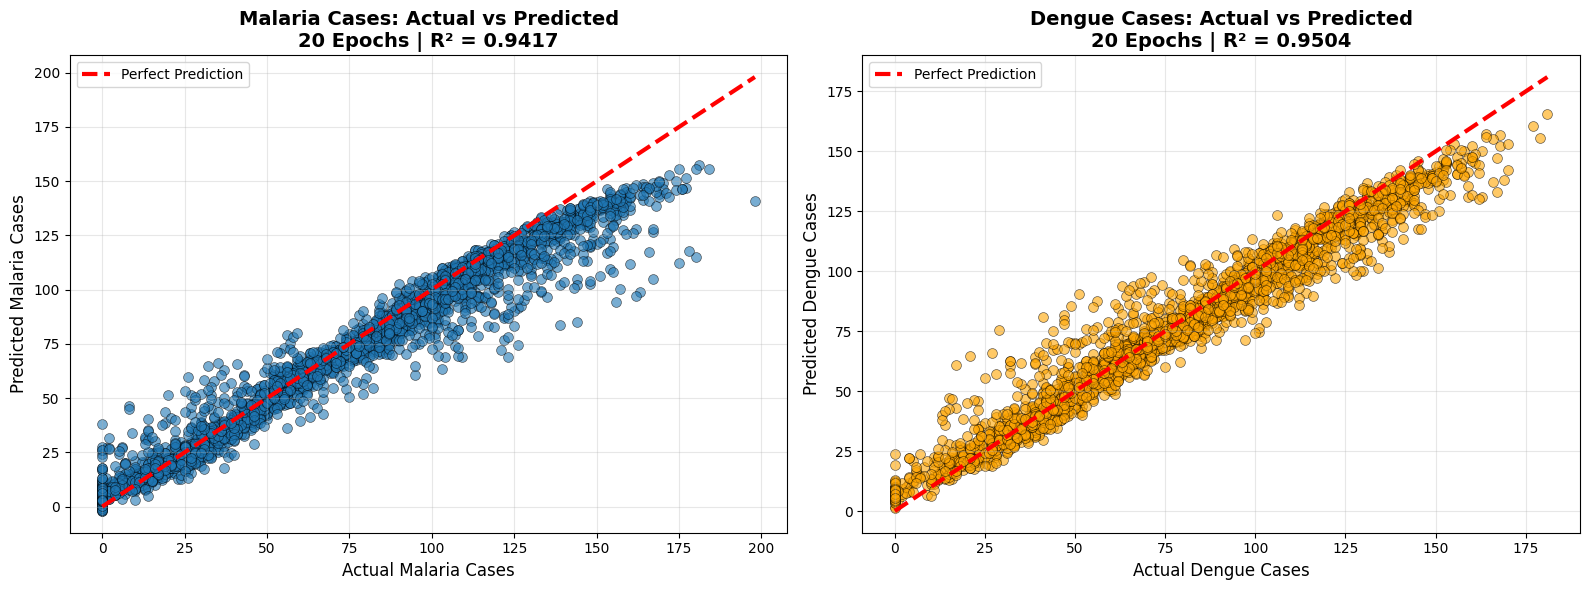

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].scatter(y_test['malaria_cases'], y_pred[:, 0],
                alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[0].plot([y_test['malaria_cases'].min(), y_test['malaria_cases'].max()],
             [y_test['malaria_cases'].min(), y_test['malaria_cases'].max()],
             'r--', lw=3, label='Perfect Prediction')
axes[0].set_title(f'Malaria Cases: Actual vs Predicted\n{best_config[0]} | R² = {r2_malaria:.4f}',
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Actual Malaria Cases', fontsize=12)
axes[0].set_ylabel('Predicted Malaria Cases', fontsize=12)
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

axes[1].scatter(y_test['dengue_cases'], y_pred[:, 1],
                alpha=0.6, s=50, color='orange', edgecolors='black', linewidth=0.5)
axes[1].plot([y_test['dengue_cases'].min(), y_test['dengue_cases'].max()],
             [y_test['dengue_cases'].min(), y_test['dengue_cases'].max()],
             'r--', lw=3, label='Perfect Prediction')
axes[1].set_title(f'Dengue Cases: Actual vs Predicted\n{best_config[0]} | R² = {r2_dengue:.4f}',
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Actual Dengue Cases', fontsize=12)
axes[1].set_ylabel('Predicted Dengue Cases', fontsize=12)
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()